In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import numpy as np
from scipy.ndimage import distance_transform_edt as edt
import matplotlib.pyplot as plt


In [2]:
class MNISTSDF(Dataset):
    def __init__(self, split='train', size=64, sample_points=None, data_root='./data'):
        self.size = size
        self.sample_points = sample_points
        self.ds = datasets.MNIST(data_root, train=(split=='train'), download=True)
        self.to_tensor = transforms.Compose([
            transforms.Resize((size, size), antialias=True),
            transforms.ToTensor()
        ])
        # compat meshgrid
        ys, xs = torch.linspace(-1,1,size), torch.linspace(-1,1,size)
        yy, xx = torch.meshgrid(ys, xs)  # works everywhere
        self.coords_full = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        img_pil, _ = self.ds[idx]
        img = self.to_tensor(img_pil)[0].numpy()
        mask = (img >= 0.5).astype(np.uint8)

        # signed distance (negative inside), normalized by diagonal
        dist_out = edt(1 - mask).astype(np.float32)
        dist_in  = edt(mask).astype(np.float32)
        sdf = (dist_out - dist_in) / np.sqrt(self.size**2 + self.size**2)

        coords = self.coords_full
        sdf_flat = torch.from_numpy(sdf).view(-1,1)

        if self.sample_points is not None and self.sample_points < coords.shape[0]:
            ids = torch.randperm(coords.shape[0])[:self.sample_points]
            coords, sdf_flat = coords[ids], sdf_flat[ids]

        return {
            "idx": idx,
            "coords": coords.float(),           # [N,2]
            "sdf": sdf_flat.float(),            # [N,1]
            "sdf_full": torch.from_numpy(sdf)[None].float()  # [1,H,W]
            # "label": label,  # optional
        }


/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474892959/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


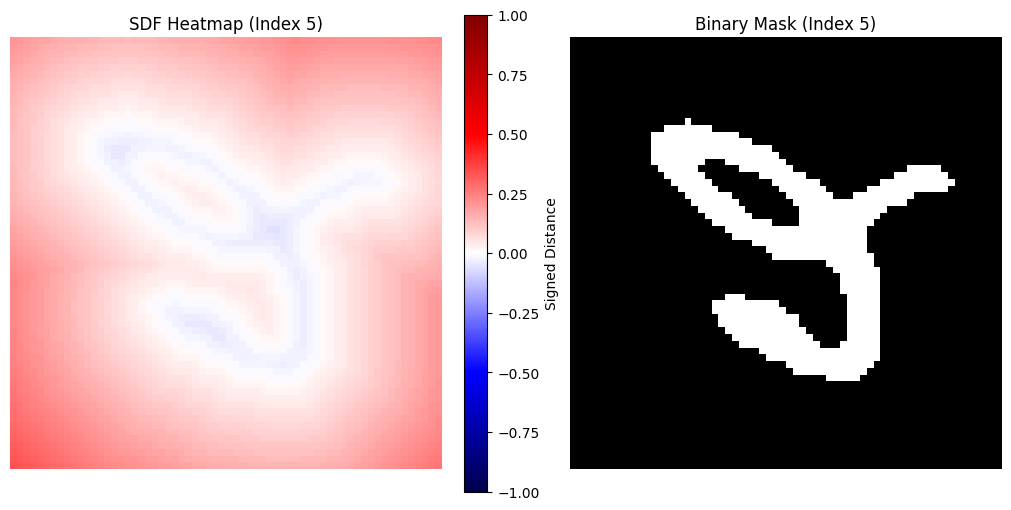

In [3]:
# create dataset
ds = MNISTSDF(split='train', size=64, sample_points=None)

# pick an index to view
idx_to_view = 5
sample = ds[idx_to_view]

# unpack
coords = sample["coords"]
sdf_full = sample["sdf_full"].numpy()[0]  # [H,W]
digit_label = idx_to_view  # optional

# plot SDF heatmap and Binary Mask with the same height
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Plot SDF heatmap
im0 = axes[0].imshow(sdf_full, cmap='seismic', origin='lower', vmin=-1, vmax=1)
axes[0].set_title(f"SDF Heatmap (Index {idx_to_view})")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], label='Signed Distance')

# Plot Binary Mask
binary_mask = (sdf_full < 0).astype(float)
im1 = axes[1].imshow(binary_mask, cmap='gray', origin='lower')
axes[1].set_title(f"Binary Mask (Index {idx_to_view})")
axes[1].axis('off')

plt.show()


In [4]:
# dataset for full grids (good for viz) or subsampled (fast DeepSDF)
ds_full  = MNISTSDF(split='train', size=64, sample_points=None)
ds_sub   = MNISTSDF(split='train', size=64, sample_points=4096)

# Model DeepSDF

In [5]:
# class DeepSDF(nn.Module):
#     def __init__(self, z_dim=64, width=128, depth=4):
#         super().__init__()
#         self.z_dim = z_dim
#         layers=[]; last=2+z_dim
#         for _ in range(depth):
#             layers += [nn.Linear(last, width), nn.ReLU(inplace=True)]
#             last = width
#         layers += [nn.Linear(last, 1)]
#         self.net = nn.Sequential(*layers)
#     def forward(self, coords, z):
#         if z.dim()==1: z = z[None,:]
#         N = coords.shape[0]
#         zrep = z[:,None,:].expand(1,N,z.shape[-1]).reshape(N,-1)
#         return self.net(torch.cat([coords, zrep], -1))

class DeepSDF(nn.Module):
    def __init__(self, z_dim=64, width=128, depth=4):
        super().__init__()
        layers = []; last = 2 + z_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU(inplace=True)]
            last = width
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, coords, z):
        # coords: (B,N,2) or (N,2); z: (B,D) or (D,)
        if coords.dim() == 2:
            coords = coords[None, ...]
        if z.dim() == 1:
            z = z[None, ...]
        B, N, _ = coords.shape
        zrep = z[:, None, :].expand(B, N, z.shape[-1])
        x = torch.cat([coords, zrep], dim=-1).reshape(B * N, -1)
        out = self.net(x).reshape(B, N, 1)
        return out



def sdf_loss(pred, gt, band=0.2):
    p = pred.squeeze(-1); g = gt.squeeze(-1)
    near = (g.abs() < band).float()
    l_sdf = (near * (p - g).abs()).mean()
    occ = torch.sigmoid(-p)                 # negative => inside
    l_occ = F.binary_cross_entropy(occ, (g < 0).float())
    return l_sdf + 0.5*l_occ

def clamped_l1(pred, gt, δ=0.1):
    return torch.clamp((pred-gt).abs(), max=δ).mean()



In [6]:
# --- data ---
def collate(batch):
    coords = torch.stack([b["coords"]   for b in batch], 0)  # (B,N,2)
    sdf    = torch.stack([b["sdf"]      for b in batch], 0)  # (B,N,1)
    idx    = torch.tensor([b["idx"]     for b in batch], dtype=torch.long)
    return coords, sdf, idx

train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# create dataset
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=collate
)



# Use your MNISTSDF class; subsample for speed if needed
# train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True, collate_fn=lambda x: x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- data ---
def collate(batch):
    coords = torch.stack([b["coords"]   for b in batch], 0)  # (B,N,2)
    sdf    = torch.stack([b["sdf"]      for b in batch], 0)  # (B,N,1)
    idx    = torch.tensor([b["idx"]     for b in batch], dtype=torch.long)
    return coords, sdf, idx

train_ds = MNISTSDF(split='train', size=64, sample_points=4096)
# create dataset
train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=True,
    collate_fn=collate
)



model = DeepSDF(z_dim=64, width=128, depth=4).to(device)

latents = nn.Embedding(len(train_ds), 64, sparse=True).to(device)
nn.init.normal_(latents.weight, mean=0.0, std=0.01)

opt_theta = torch.optim.Adam(model.parameters(), lr=5e-4)
opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=1e-3)

scaler = torch.cuda.amp.GradScaler()
λ = 1e-3  # a bit stronger prior is helpful on MNIST

for ep in range(1, 6):
    model.train(); losses=[]
    for coords, sdf, idx in train_loader:
        coords = coords.to(device, non_blocking=True)
        sdf    = sdf.to(device, non_blocking=True)
        idx    = idx.to(device, non_blocking=True)

        z = latents(idx)  # (B,64)

        opt_theta.zero_grad(set_to_none=True)
        opt_z.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast():
            pred = model(coords, z)          # (B,N,1)
            loss = sdf_loss(pred, sdf) + λ * z.pow(2).mean()

        scaler.scale(loss).backward()
        scaler.step(opt_theta); scaler.step(opt_z)
        scaler.update()

        losses.append(loss.item())
    print(f"epoch {ep} | train {np.mean(losses):.4e}")


/tmp/ipykernel_2476522/3919603347.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipykernel_2476522/3919603347.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/azhir/miniconda3/envs/metaPDE/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

# ---------- loss ----------
@torch.cuda.amp.autocast(enabled=False)
def sdf_occ_loss(pred_sdf, gt_sdf, band=0.2):
    # pred_sdf, gt_sdf: (B,N,1)
    p = pred_sdf.squeeze(-1)
    g = gt_sdf.squeeze(-1)

    # near-surface L1
    near = (g.abs() < band).float()
    l_sdf = (near * (p - g).abs()).sum() / (near.sum().clamp_min(1.0))

    # occupancy/sign (inside if sdf<0)
    occ_pred = torch.sigmoid(-p)
    occ_tgt  = (g < 0).float()
    l_occ = F.binary_cross_entropy(occ_pred, occ_tgt)

    return l_sdf + 0.5 * l_occ

# ---------- fast trainer ----------
def train_deepsdf_fast(
    train_ds, model, device="cuda",
    z_dim=64, batch_size=32, points_per_step=4096,
    lr_theta=5e-4, lr_z=1e-3, weight_decay=1e-4,
    lambda_z=1e-3, epochs=5, num_workers=4, amp=True, compile_model=True
):
    loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers>0),
        collate_fn=lambda batch: (
            torch.stack([b["coords"] for b in batch], 0),  # (B,N,2)
            torch.stack([b["sdf"]    for b in batch], 0),  # (B,N,1)
            torch.tensor([b["idx"]   for b in batch], dtype=torch.long),
        )
    )

    # per-sample latents (sparse updates)
    latents = nn.Embedding(len(train_ds), z_dim, sparse=True).to(device)
    nn.init.normal_(latents.weight, mean=0.0, std=0.01)

    model = model.to(device)
    if compile_model and hasattr(torch, "compile"):
        model = torch.compile(model)

    opt_theta = torch.optim.AdamW(model.parameters(), lr=lr_theta, weight_decay=weight_decay)
    opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=lr_z)

    # cosine LR (optional but nice)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt_theta, T_max=epochs, eta_min=lr_theta*0.1)

    scaler = torch.cuda.amp.GradScaler(enabled=amp)

    model.train()
    for ep in range(1, epochs+1):
        losses = []
        for coords, sdf, idx in loader:
            coords = coords.to(device, non_blocking=True)  # (B,N,2)
            sdf    = sdf.to(device, non_blocking=True)     # (B,N,1)
            idx    = idx.to(device, non_blocking=True)     # (B,)

            # subsample points per step for speed
            B, N, _ = coords.shape
            if N > points_per_step:
                sel = torch.randint(0, N, (points_per_step,), device=device)
                coords = coords[:, sel]
                sdf    = sdf[:, sel]

            z = latents(idx)  # (B, z_dim)

            opt_theta.zero_grad(set_to_none=True)
            opt_z.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=amp):
                pred = model(coords, z)                       # (B, npts, 1)
                loss = sdf_occ_loss(pred, sdf) + lambda_z * z.pow(2).mean()

            scaler.scale(loss).backward()
            scaler.step(opt_theta)
            scaler.step(opt_z)
            scaler.update()

            losses.append(loss.item())

        sched.step()
        print(f"epoch {ep} | train {np.mean(losses):.4e} | lr {sched.get_last_lr()[0]:.2e}")

    return model, latents


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = DeepSDF(z_dim=64, width=128, depth=4).to(device)

# latents = nn.Embedding(len(train_ds), 64, sparse=True).to(device)
# nn.init.normal_(latents.weight, mean=0.0, std=0.01)

# opt_theta = torch.optim.Adam(model.parameters(), lr=3e-4)
# opt_z     = torch.optim.SparseAdam(latents.parameters(), lr=1e-3)

In [ ]:
# # --- train ---
# EPOCHS=5
# for ep in range(1, EPOCHS+1):
#     model.train(); latents.train(); losses=[]
#     for batch in train_loader:
#         opt_theta.zero_grad(); opt_z.zero_grad()
#         total = 0.0
#         for b in batch:
#             idx = b["idx"]
#             x   = b["coords"].to(device)
#             y   = b["sdf"].to(device)
#             z   = latents(torch.tensor(idx, device=device))
#             pred = model(x, z)
#             loss = sdf_loss(pred, y) + 1e-4 * z.pow(2).mean()  # small latent L2
#             total = total + loss
#         (total/len(batch)).backward()
#         opt_theta.step(); opt_z.step()
#         losses.append(total.item()/len(batch))
#     print(f"epoch {ep}/{EPOCHS} | train {np.mean(losses[-100:]):.4e}")


KeyboardInterrupt: 

In [ ]:
# pip install scipy torchvision
import math, numpy as np, torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from scipy.ndimage import distance_transform_edt as edt

# ---------- caching ----------
_GRID_CACHE = {}
def get_xy_grid(H, W, device="cpu", dtype=torch.float32):
    key = (H, W, device, dtype)
    if key in _GRID_CACHE: return _GRID_CACHE[key]
    ys = torch.linspace(-1, 1, H, device=device, dtype=dtype)
    xs = torch.linspace(-1, 1, W, device=device, dtype=dtype)
    yy, xx = torch.meshgrid(ys, xs, indexing='ij')
    grid = torch.stack([xx, yy], dim=-1) # [H, W, 2]
    _GRID_CACHE[key] = grid
    return grid

# ---------- image -> SDF ----------
def img_to_sdf(img_pil, size=(128,128), thresh=0.5, morph_close=False):
    """
    Returns:
      sdf_t: torch.float32 [H, W], negative inside, positive outside, normalized by max(H,W)
      mask_t: torch.uint8 [H, W]   (1 = inside)
    """
    to_tensor = transforms.Compose([
        transforms.Resize(size, antialias=True),
        transforms.ToTensor()  # [1,H,W], 0..1
    ])
    img = to_tensor(img_pil)[0].numpy()

    # Optional small morphology to remove salt/pepper (kept off by default)
    if morph_close:
        from scipy.ndimage import binary_closing
        mask = binary_closing(img >= thresh, structure=np.ones((3,3), dtype=bool)).astype(np.uint8)
    else:
        mask = (img >= thresh).astype(np.uint8)

    # Signed distance (negative inside):
    #   sdf = dist(outside) - dist(inside)
    d_out = edt(1 - mask)
    d_in  = edt(mask)
    sdf   = d_out - d_in

    # Scale-normalize so magnitudes are comparable across resolutions
    scale = float(max(img.shape))  # max(H,W)
    sdf   = sdf / scale

    sdf_t  = torch.from_numpy(sdf.astype(np.float32))
    mask_t = torch.from_numpy(mask.astype(np.uint8))
    return sdf_t, mask_t


In [ ]:
def _div_k_grad(u, k):
    """
    Compute ∇·(k ∇u) with 2D forward/backward differences and edge replication.
    Shapes: u,k -> [H,W] tensors (float32)
    """
    # Pad for boundaries (replicate = Neumann-like)
    u = u.unsqueeze(0).unsqueeze(0)        # [1,1,H,W]
    k = k.unsqueeze(0).unsqueeze(0)

    # Differences in x (W) and y (H)
    ux = u[..., :, 1:] - u[..., :, :-1]                      # [1,1,H,W-1]
    uy = u[..., 1:, :] - u[..., :-1, :]                      # [1,1,H-1,W]
    kx = 0.5 * (k[..., :, 1:] + k[..., :, :-1])
    ky = 0.5 * (k[..., 1:, :] + k[..., :-1, :])

    # Fluxes
    fx = kx * ux
    fy = ky * uy

    # Divergence (backward diffs with padding)
    # x-direction
    fx_pad_l = F.pad(fx, (1,0,0,0), mode='replicate')
    fx_pad_r = F.pad(fx, (0,1,0,0), mode='replicate')
    divx = fx_pad_r - fx_pad_l
    # y-direction
    fy_pad_t = F.pad(fy, (0,0,1,0), mode='replicate')
    fy_pad_b = F.pad(fy, (0,0,0,1), mode='replicate')
    divy = fy_pad_b - fy_pad_t

    div = divx + divy
    return div.squeeze(0).squeeze(0)  # [H,W]


def heat_on_sdf(sdf, steps=50, dt=None, k_inside=1.0, k_outside=0.2, source=None, device="cpu"):
    """
    u_t = ∇·(k ∇u) + f  with k piecewise from SDF sign.
    Start from u0 = sdf (or zeros); returns u after 'steps'.
    """
    sdf = sdf.to(device)
    H, W = sdf.shape
    k = torch.where(sdf < 0, torch.tensor(k_inside, device=device), torch.tensor(k_outside, device=device))
    u = sdf.clone()  # or torch.zeros_like(sdf)

    # Stable dt for 5-pt stencil: dt <= 0.25 / max(k) in 2D (safe choice if dt is None)
    if dt is None:
        dt = 0.2 / float(max(k_inside, k_outside))

    if source is None:
        source = torch.zeros_like(u)

    for _ in range(steps):
        u = u + dt * (_div_k_grad(u, k) + source)
    return u


def cg(Ax, b, maxiter=500, tol=1e-6):
    """
    Minimal Conjugate Gradient in PyTorch for SPD operators.
    Ax: callable(x)->Ax, x,b are [H,W] tensors
    """
    x = torch.zeros_like(b)
    r = b - Ax(x)
    p = r.clone()
    rs = torch.dot(r.flatten(), r.flatten())
    for _ in range(maxiter):
        Ap = Ax(p)
        denom = torch.dot(p.flatten(), Ap.flatten()) + 1e-12
        alpha = rs / denom
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.dot(r.flatten(), r.flatten())
        if torch.sqrt(rs_new) < tol:
            break
        p = r + (rs_new / (rs + 1e-12)) * p
        rs = rs_new
    return x


def darcy_on_sdf(sdf, k_inside=1.0, k_outside=0.1, f=None, device="cpu", maxiter=400, tol=1e-6):
    """
    Solve steady -∇·(k∇u) = f with Neumann-like edges via replicate padding.
    If f is None, uses a balanced source on the digit to avoid singularity.
    Returns u with zero-mean (unique up to a constant under Neumann BCs).
    """
    sdf = sdf.to(device)
    H, W = sdf.shape
    k = torch.where(sdf < 0, torch.tensor(k_inside, device=device), torch.tensor(k_outside, device=device))

    if f is None:
        # Unit source inside, sink outside to ensure ∫ f = 0 (SPD with Neumann)
        mask = (sdf < 0).float()
        pos = mask / (mask.sum() + 1e-12)
        neg = (1.0 - mask) / ((1.0 - mask).sum() + 1e-12)
        f = pos - neg

    def Ax(u):
        return -_div_k_grad(u, k)

    u = cg(Ax, f, maxiter=maxiter, tol=tol)
    # Fix DC ambiguity (mean)
    u = u - u.mean()
    return u


In [ ]:
class MNISTSDFPDEDataset(torch.utils.data.Dataset):
    def __init__(self, split="train", size=(128,128), pde="heat",
                 thresh=0.5, morph_close=False, device="cpu",
                 heat_steps=50, heat_dt=None,
                 k_inside=1.0, k_outside=0.2):
        assert pde in {"heat", "darcy"}
        self.size = size if isinstance(size, tuple) else (size, size)
        self.H, self.W = self.size
        self.pde = pde
        self.thresh = thresh
        self.morph_close = morph_close
        self.device = device
        self.heat_steps = heat_steps
        self.heat_dt = heat_dt
        self.k_inside = float(k_inside)
        self.k_outside = float(k_outside)

        self.ds = datasets.MNIST("./data", train=(split=="train"), download=True)

        # cache coord grid on chosen device
        self.coords = get_xy_grid(self.H, self.W, device=device)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img_pil, label = self.ds[idx]  # label unused here, returned for convenience
        sdf, mask = img_to_sdf(img_pil, size=self.size, thresh=self.thresh, morph_close=self.morph_close)
        sdf = sdf.to(self.device)
        mask = mask.to(self.device)

        if self.pde == "heat":
            u = heat_on_sdf(sdf, steps=self.heat_steps, dt=self.heat_dt,
                            k_inside=self.k_inside, k_outside=self.k_outside, device=self.device)
        else:
            u = darcy_on_sdf(sdf, k_inside=self.k_inside, k_outside=self.k_outside, device=self.device)

        return {
            "coords": self.coords,     # [H,W,2], in [-1,1]
            "sdf": sdf,                # [H,W], float32 (neg inside)
            "mask": mask,              # [H,W], uint8
            "pde": u,                  # [H,W], float32
            "label": label             # digit class, optional
        }


In [ ]:
# 64x64 Heat
train_ds = MNISTSDFPDEDataset(split="train", size=64, pde="heat",
                               k_inside=1.0, k_outside=0.2, heat_steps=60, device="cpu")
ex = train_ds[0]
coords, sdf, u = ex["coords"], ex["sdf"], ex["pde"]

# 128x128 Darcy
test_ds = MNISTSDFPDEDataset(split="test", size=(128,128), pde="darcy",
                              k_inside=1.0, k_outside=0.05, device="cpu")
ex2 = test_ds[0]


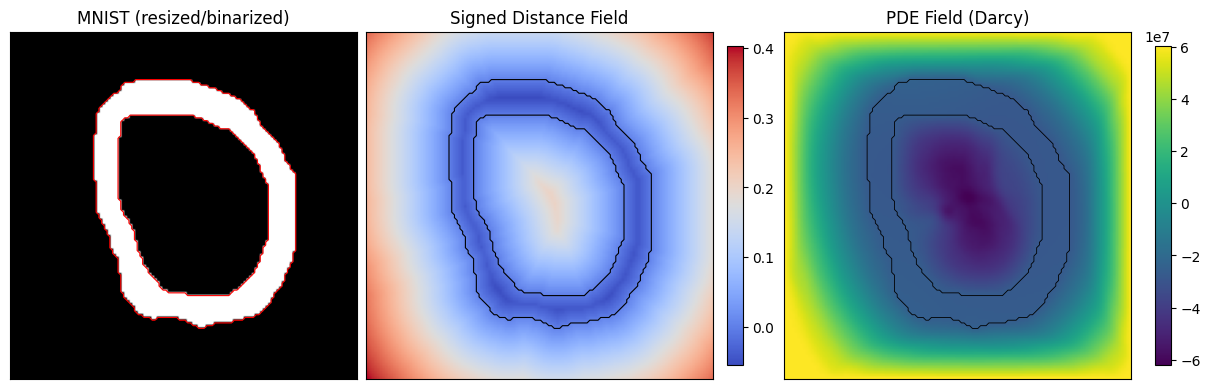

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

ex = test_ds[10]

coords = ex["coords"]
sdf    = ex["sdf"]
mask   = ex["mask"]
pde    = ex["pde"]

# Move to CPU + numpy
coords = coords.cpu().numpy()
sdf    = sdf.cpu().numpy()
mask   = mask.cpu().numpy().astype(np.float32)
pde    = pde.cpu().numpy()

# For pretty axes: map pixels to [-1,1] using coords
x_min, x_max = coords[...,0].min(), coords[...,0].max()
y_min, y_max = coords[...,1].min(), coords[...,1].max()
extent = [x_min, x_max, y_min, y_max]  # (left, right, bottom, top)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# 1) MNIST (binary mask as a proxy for the digit)
im0 = axs[0].imshow(mask, cmap="gray", origin="lower", extent=extent)
axs[0].set_title("MNIST (resized/binarized)")
axs[0].contour(sdf, levels=[0.0], colors="r", linewidths=0.8, extent=extent)  # zero level-set overlay

# 2) SDF field (blue/red with zero-level contour)
im1 = axs[1].imshow(sdf, cmap="coolwarm", origin="lower", extent=extent)
axs[1].set_title("Signed Distance Field")
axs[1].contour(sdf, levels=[0.0], colors="k", linewidths=0.8, extent=extent)
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# 3) PDE field (Darcy solution) with the interface overlay
im2 = axs[2].imshow(pde, cmap="viridis", origin="lower", extent=extent)
axs[2].set_title("PDE Field (Darcy)")
axs[2].contour(sdf, levels=[0.0], colors="k", linewidths=0.6, extent=extent)
fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.set_xticks([]); ax.set_yticks([])

plt.show()
